### Домашнее задание к лекции 3

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

4.  Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    
5. Оцените результат моделирования

6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

import itertools

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

from random import random
import warnings
warnings.filterwarnings("ignore") # отключает предупреждения

In [3]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


**Посмотрим на точность модели ARIMAX с годовой сезонностьтю. Сделаем ресемплнг по месячно.**

In [4]:
data_m = data.copy().resample('M').mean()
data_m.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714
2002-03-31,28875.256720,2002.0,3.0,16.000000,1.0,75.000000,11.258065,3.193548,11.500000,0.000000,0.000000,0.000000
2002-04-30,28534.731572,2002.0,4.0,15.511822,2.0,105.511822,15.668985,2.828929,11.511822,0.000000,0.000000,0.000000
2002-05-31,28073.653226,2002.0,5.0,16.000000,2.0,136.000000,20.000000,3.000000,11.500000,0.032258,0.032258,0.032258


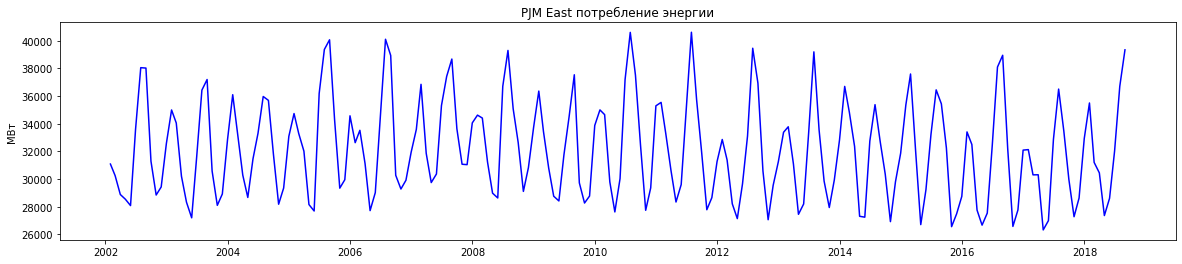

In [5]:
plt.figure(figsize =(20,4))
plt.plot( data_m.index, data_m['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

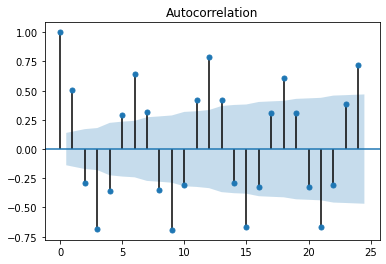

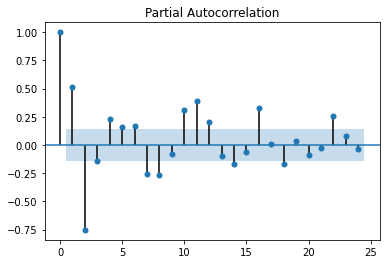

In [6]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=24)
plt.show()

sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=24)
plt.show()

Подобрать параметры модели можно используя сеточный выбор как это сделано для ряда "Потребление энергии" ниже:

- На основании анализа выбираем диапазон изменения параметров сезонности и остатка ряда.
    
- задаем длину сезона (12 - полный сезон или  6 месяцев - зимой греем, летом кондиционируем и расход энергии примерно одинаковый)
    
- Запускаем генерацию сетки с использованием модуля itertools (itertools.product(p, d, q) - сгенерит декартово множество по p,d,q диапазонам) и задаем полный список вариантов.
    
- Запускаем генерацию SARIMAX - с параметрами и возвращаем AIC.
    
- Лучшее значение параметров (при минимальной оценке AIC) используем для настройки финальной модели.

In [7]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
def set_params(trend: dict, season: dict, len_season):
    trend_param = list(itertools.product(trend.get('p'), trend.get('d'), trend.get('q')))
    season_param = [(x[0], x[1], x[2], len_season) for x in list(itertools.product(season.get('p'), season.get('d'), season.get('q')))]
    return trend_param, season_param

In [9]:
def get_best_model(df, target_coll: str, trend: dict, season: dict, len_season: int, test_part = 0.3, n_start = 0):
    trend_param, season_param = set_params(trend, season, len_season);
    param_aic = []
    for param in trend_param:
        for param_seasonal in season_param:
            mod = sm.tsa.statespace.SARIMAX(df[target_coll].values,order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

            results = mod.fit()
            param_aic.append([param, param_seasonal, results.aic])

    best_param = sorted(param_aic, key=lambda param_aic: param_aic[2])[0]
    print('BEST PARAMs: ARIMA{}x{}3 - AIC:{}'.format(best_param[0], best_param[1], best_param[2]))
    
    n_test = int(df.shape[0] * test_part)
    model_for_metrics = sm.tsa.statespace.SARIMAX(df[target_coll].values[n_start:-n_test],order=best_param[0],
                                seasonal_order=best_param[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    
    
    mod_metrs = model_for_metrics.fit()
    
    y_true = df[target_coll].values[-n_test:]
    y_pred = mod_metrs.forecast(n_test)
    print(f'Точность на тесте: \nMAE = {mean_absolute_error(y_true, y_pred)}, MAPE = {mape(y_true, y_pred)}')
    
    final_model = sm.tsa.statespace.SARIMAX(df[target_coll].values[n_start:],order=best_param[0],
                                seasonal_order=best_param[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results_opt = final_model.fit()
    
    print(results_opt.summary().tables[0],results_opt.summary().tables[1])
    results_opt.plot_diagnostics(figsize=(15, 12))
    plt.show()
    return results_opt

In [10]:
def predict(df, target, model, forecast_part = 0.3, left_margin = 0.1):
    nforecast = int(df.shape[0] * forecast_part)
    n_left_marging = int(df.shape[0] * left_margin)  # отступ данных для отображения  модели 
    
    predict_ = model.get_prediction(end=model.nobs + nforecast)  # делаем предсказание
        
    idx = np.arange(len(predict_.predicted_mean)-n_left_marging)
    predict_ci = predict_.conf_int(alpha=0.05)
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax.xaxis.grid()
    ax.plot(df[target].values[n_left_marging:], 'k.',label='true')
    
    ax.plot(idx[:-nforecast], predict_.predicted_mean[n_left_marging:-nforecast], 'gray',label = 'model')
    ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
    ax.fill_between(idx, predict_ci[n_left_marging:, 0], predict_ci[n_left_marging:, 1], alpha=0.25)
    plt.legend()
    ax.set(title='общая картина моделирование и предсказание');


In [11]:
# Определим p, d и q 
pdq = {'p':range(0, 2),
       'd':range(0, 1),
       'q':range(0, 2)}
pdq_s = {'p':range(0, 1),
       'd':range(0, 2),
       'q':range(0, 2)}

BEST PARAMs: ARIMA(1, 0, 1)x(0, 1, 1, 12)3 - AIC:3093.709013047035
Точность на тесте: 
MAE = 1390.838020323444, MAPE = 4.258367034290881
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  200
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1542.855
Date:                            Fri, 06 Nov 2020   AIC                           3093.709
Time:                                    10:57:02   BIC                           3106.345
Sample:                                         0   HQIC                          3098.835
                                            - 200                                         
Covariance Type:                              opg                                         
========================================================================================== ============================================

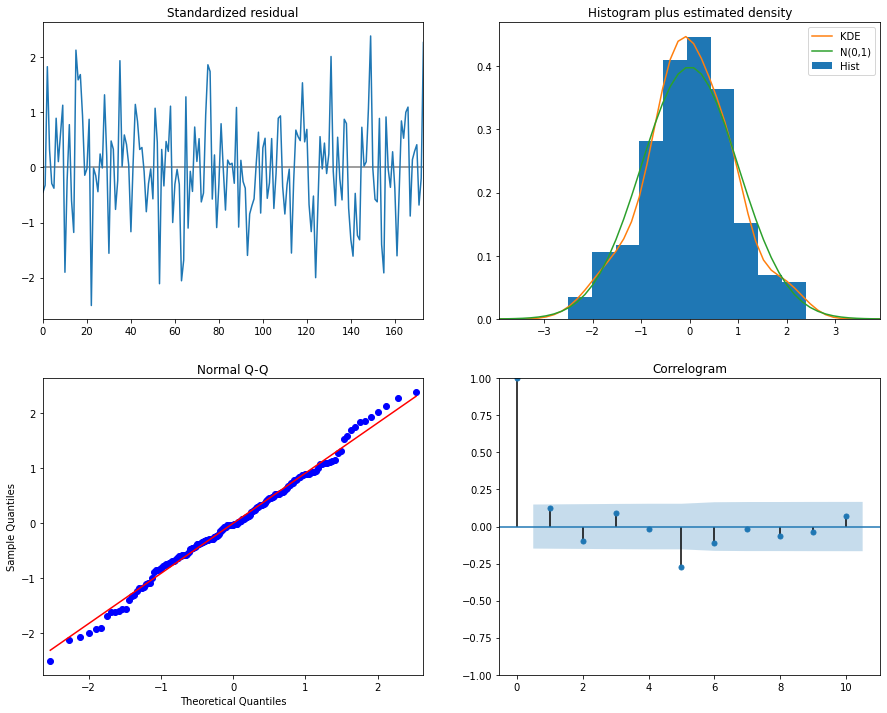

In [12]:
model = get_best_model(data_m, 'PJME_MW', pdq,  pdq_s, 12);

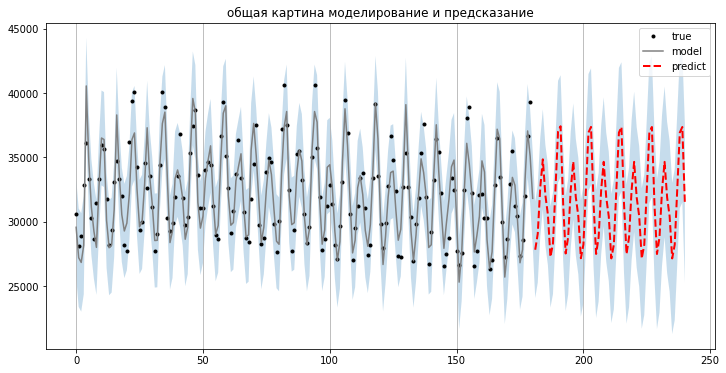

In [13]:
predict(data_m, 'PJME_MW', model, forecast_part = 0.3, left_margin = 0.1)

**Посмотрим на точность с недельной сезонностью. Сделаем суточный ресемплинг**

In [14]:
data_d = data.copy().resample('D').mean()
data_d.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-01,31080.739130,2002.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,0.0,0.0
2002-01-02,34261.541667,2002.0,1.0,2.0,1.0,2.0,1.0,2.0,11.5,0.0,0.0,1.0
2002-01-03,34511.875000,2002.0,1.0,3.0,1.0,3.0,1.0,3.0,11.5,0.0,0.0,0.0
2002-01-04,33715.458333,2002.0,1.0,4.0,1.0,4.0,1.0,4.0,11.5,0.0,0.0,0.0
2002-01-05,30405.125000,2002.0,1.0,5.0,1.0,5.0,1.0,5.0,11.5,0.0,0.0,0.0


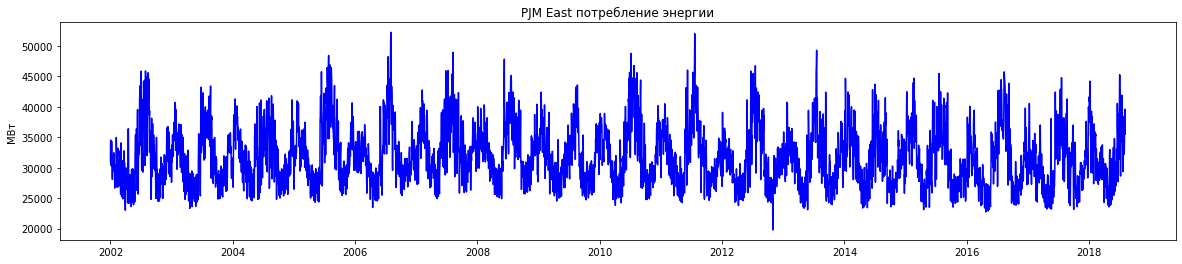

In [15]:
plt.figure(figsize =(20,4))
plt.plot( data_d.index, data_d['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

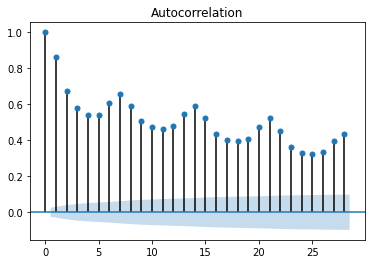

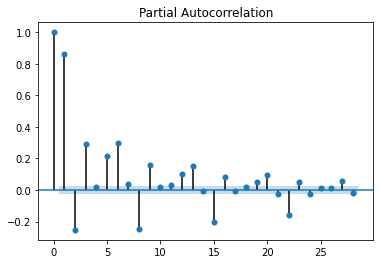

In [16]:
sm.graphics.tsa.plot_acf(data_d['PJME_MW'].values, lags=28)
plt.show()

sm.graphics.tsa.plot_pacf(data_d['PJME_MW'].values, lags=28)
plt.show()

In [17]:
# Определим p, d и q 
pdq = {'p':range(0, 2),
       'd':range(0, 1),
       'q':range(0, 2)}
pdq_s = {'p':range(0, 1),
       'd':range(0, 2),
       'q':range(0, 2)}

BEST PARAMs: ARIMA(1, 0, 1)x(0, 1, 1, 7)3 - AIC:107702.54729569382
Точность на тесте: 
MAE = 3905.0901330464517, MAPE = 12.856784233849705
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 6059
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -53847.274
Date:                           Fri, 06 Nov 2020   AIC                         107702.547
Time:                                   10:57:30   BIC                         107729.374
Sample:                                        0   HQIC                        107711.860
                                          - 6059                                         
Covariance Type:                             opg                                         
========================================================================================= ===================================================

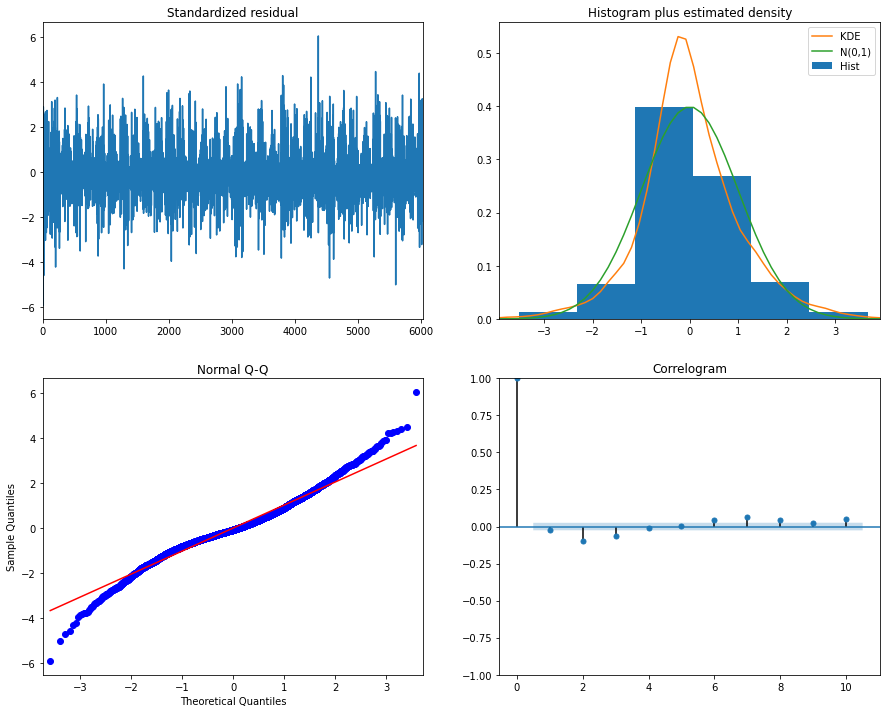

In [18]:
model = get_best_model(data_d, 'PJME_MW', pdq,  pdq_s, 7);

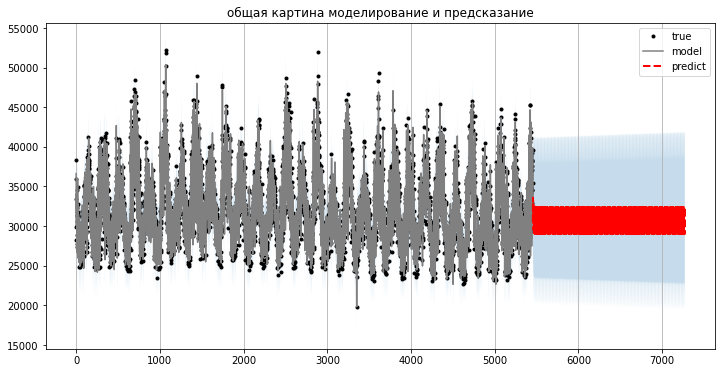

In [19]:
predict(data_d, 'PJME_MW', model, forecast_part = 0.3, left_margin = 0.1)

Посмотрим как будут работать эти модели на ARIMA (без сезонности)

In [20]:
# Определим p, d и q 
pdq = {'p':range(0, 3),
       'd':range(0, 3),
       'q':range(0, 3)}
pdq_s = {'p':[0],
       'd':[0],
       'q':[0]}

BEST PARAMs: ARIMA(2, 1, 2)x(0, 0, 0, 12)3 - AIC:3543.5028412491133
Точность на тесте: 
MAE = 2233.4437325975177, MAPE = 6.974383540516044
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1766.751
Date:                Fri, 06 Nov 2020   AIC                           3543.503
Time:                        10:57:32   BIC                           3559.893
Sample:                             0   HQIC                          3550.139
                                - 200                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025     

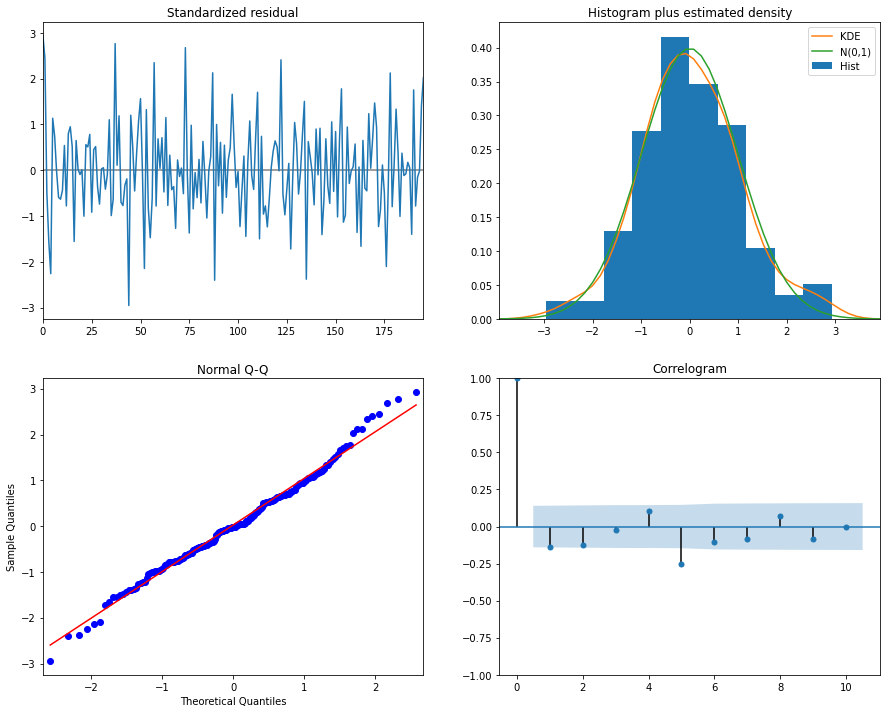

In [21]:
model_M_arima = get_best_model(data_m, 'PJME_MW', pdq,  pdq_s, 12);

BEST PARAMs: ARIMA(2, 1, 2)x(0, 0, 0, 7)3 - AIC:110140.63575989997
Точность на тесте: 
MAE = 5326.029658541422, MAPE = 18.533445898646207
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6059
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -55065.318
Date:                Fri, 06 Nov 2020   AIC                         110140.636
Time:                        10:57:49   BIC                         110174.179
Sample:                             0   HQIC                        110152.279
                               - 6059                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      

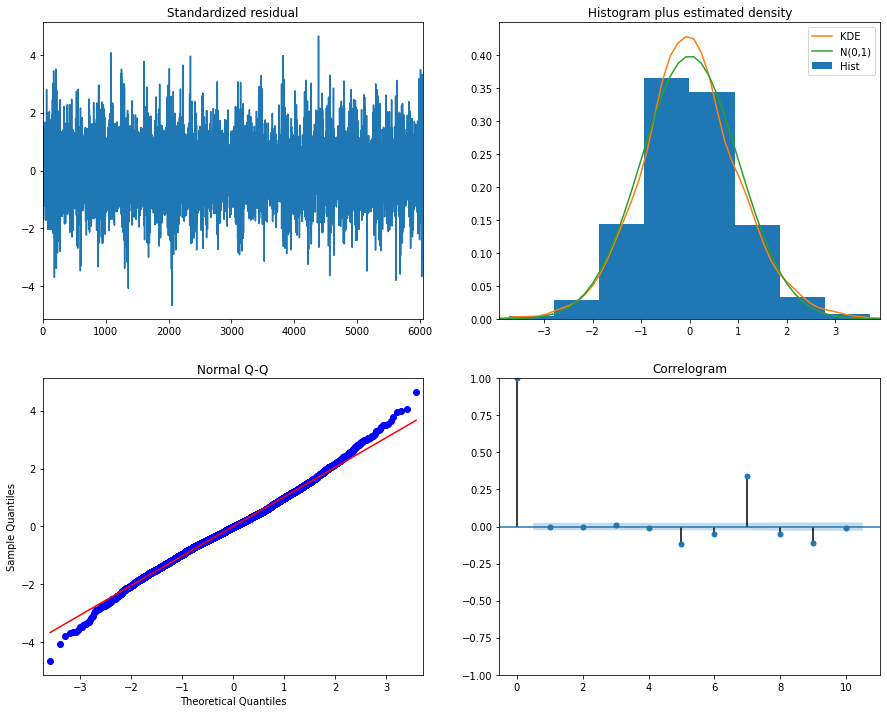

In [22]:
model_D_arima = get_best_model(data_d, 'PJME_MW', pdq,  pdq_s, 7);

Вывод: 
1. Предсказание на месячном тренде точнее, хотя для объективности надо вероятно сравнивать на относительном периоде предсказания в процентах от периодов иследуемого сезона.
2. Использование ARIMA на месячном ресемполинге дает меньшую точность, нежели при включении сезонности с SARIMAX
3. Использоание ARIMA на дневном ресемплинге дает меньшую точность по сравнению с SARIMAX

Таким образом включение информации о сезонах в модели улучшает их точность на любом ресемплинге

Построим  ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)

In [23]:
BRENT = 'my_BRENT2019.csv'
data_brent = pd.read_csv(BRENT, index_col=[0], parse_dates=[0])

data_brent.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [24]:
data_b_w = data_brent.copy().resample('W').mean()
data_b_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000


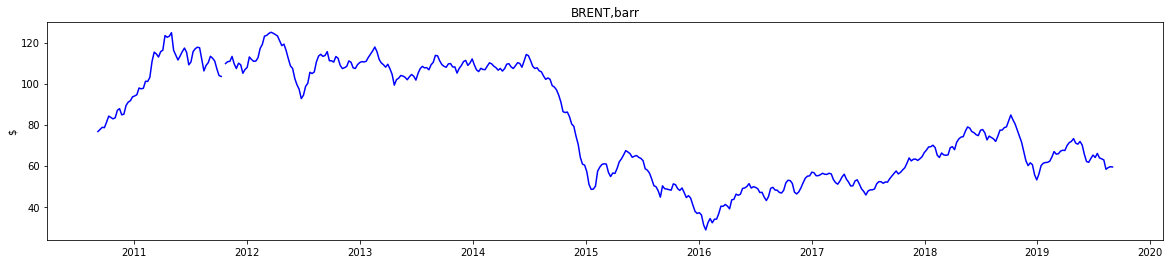

In [25]:
plt.figure(figsize =(20,4))
plt.plot( data_b_w.index, data_b_w['Значение'], 'b' )
plt.title('BRENT,barr' )
plt.ylabel ( '$' )
plt.show()

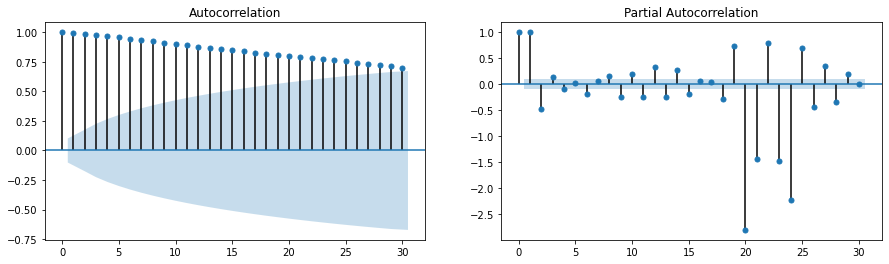

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
lag = 30
t = 100
sm.graphics.tsa.plot_acf(data_b_w['Значение'][t:].values, lags=lag, ax=axes[0])
sm.graphics.tsa.plot_pacf(data_b_w['Значение'][t:].values, lags=lag, ax=axes[1])
plt.show()

Посмотрим на ACF, PACF  первых разностей

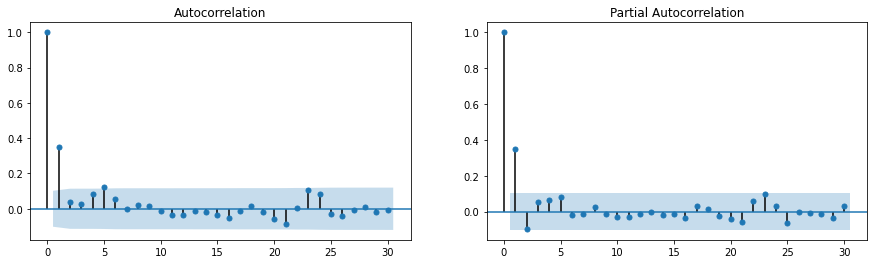

In [27]:
brent_dif = data_b_w['Значение'].diff(1) #
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
lag = 30
t = 100
sm.graphics.tsa.plot_acf(brent_dif[t:].values, lags=lag, ax=axes[0])
sm.graphics.tsa.plot_pacf(brent_dif[t:].values, lags=lag, ax=axes[1])
plt.show()

Недельные графики показывают автокорреляцию цены со всеми значениями ранее (это не очень хорошо) и для на PACF мы видим, что только 1-й порядок разностей важен для нашего процесса (AR 1). Таким образом:

Сезона нет.
ACF - медленно падает для дневныхи графиков, а для первых разностей ACF - быстро падает (не более 1-й корреляции)
PACF - быстро пададает, а для первых разностей РACF - быстро падает (не более 1-й корреляции), но при увеличении лага возрастает орицательная корреляция.

Запустим модель без сезонного анализа (ARIMA) с автоматической настройкой параметров по сетке

In [28]:
# Определим p, d и q 
pdq = {'p':range(0, 3),
       'd':range(0, 3),
       'q':range(0, 3)}
pdq_s = {'p':[0],
       'd':[0],
       'q':[0]}

BEST PARAMs: ARIMA(1, 1, 2)x(0, 0, 0, 10)3 - AIC:2022.092680053223
Точность на тесте: 
MAE = 9.323936063778259, MAPE = 13.657728018888982
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  470
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1007.046
Date:                Fri, 06 Nov 2020   AIC                           2022.093
Time:                        11:02:59   BIC                           2038.669
Sample:                             0   HQIC                          2028.617
                                - 470                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      

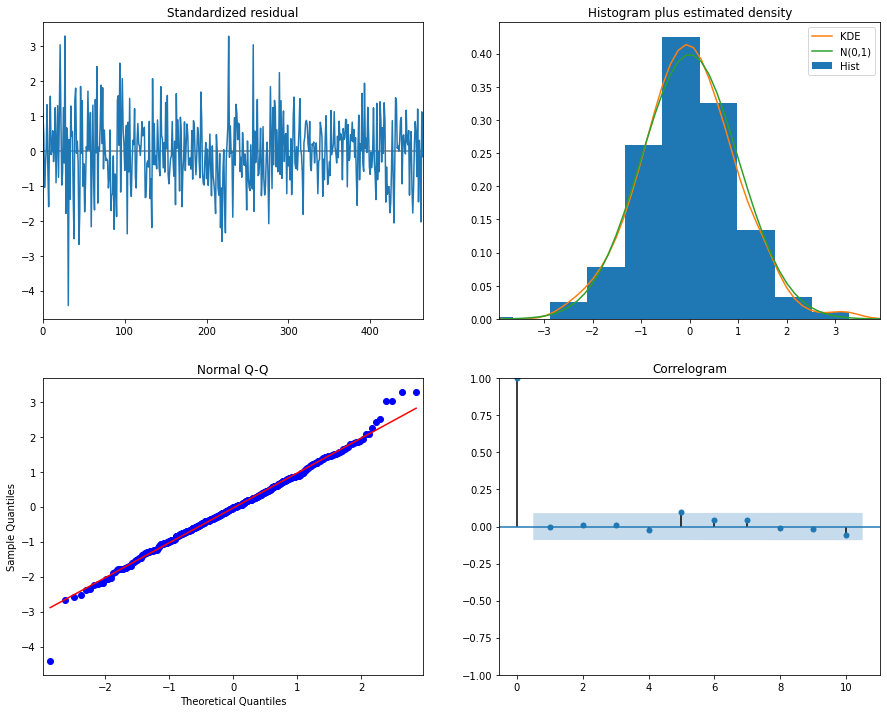

In [38]:
model_W_arima = get_best_model(data_b_w, 'Значение', pdq,  pdq_s, 10, test_part = 0.3);

BEST PARAMs: ARIMA(1, 1, 2)x(0, 0, 0, 10)3 - AIC:2022.092680053223
Точность на тесте: 
MAE = 4.634358343529839, MAPE = 7.298913074063989
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  470
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1007.046
Date:                Fri, 06 Nov 2020   AIC                           2022.093
Time:                        11:03:50   BIC                           2038.669
Sample:                             0   HQIC                          2028.617
                                - 470                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0

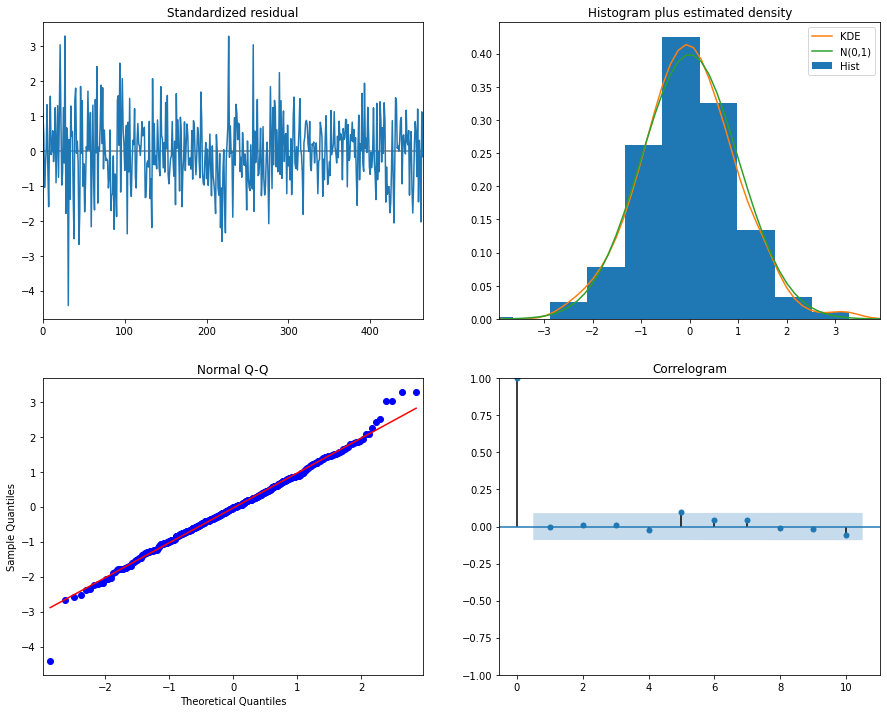

In [39]:
# посмотрим предсказание на короткие периоды - test_part = 0.05 от всего тренда
model_W_arima = get_best_model(data_b_w, 'Значение', pdq,  pdq_s, 10, test_part = 0.05);

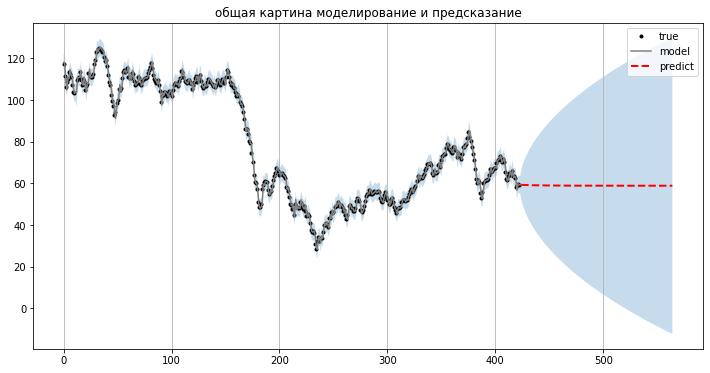

In [42]:
predict(data_b_w, 'Значение', model_W_arima, forecast_part = 0.3, left_margin = 0.1)

Вывод: модель неплохо предсказывает недельные значения, но точность MAPE достаточно низкая, и улучается при уменьшении горизонта предсказания, что в целом логично

Из всех этих экспериментов, можно предположить, что ARIMA  мы можем использовать (с аккуратностью) для предсказания проессов на которые влияют экзогенные факторы, например прогнозирование рыночных инструментов

Что касается SARIMAX то ее выгодно использовать в случае цикличных или сезонных трендов, такие как погода, тренды технологического процесса и тд